## Project Outline
* Prepare the data
* Exploratory data analysis (and some experimental features)
* Fill in the missing values
* Feature engineering
* Set up the metirc
* Grid search for base models
* Train a RandomForestClassifier as blender
* Make predictions and submit

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

/home/eric/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
sns.set_style('whitegrid')
sns.set_palette('muted')

### Prepare the data

In [3]:
# Get the data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Save the test data id in advance
passengetid = test['PassengerId']

# change the column names to lower case for convenience
train.columns = [_.lower() for _ in train.columns]
test.columns = [_.lower() for _ in test.columns]

# Get a copy of training data for experimental use
tmp = train.copy()

# Combine the data for data processing, save the separation point
sep = train.shape[0]
combine = train.drop('survived', axis=1).append(test).drop('passengerid', axis=1).reset_index(drop=True)

In [4]:
train.shape, test.shape, combine.shape

((891, 12), (418, 11), (1309, 10))

### Exploratory Data Analysis (and some experimental features)

In [5]:
# First, get a glance at the missing values
combine.isnull().sum()

pclass         0
name           0
sex            0
age          263
sibsp          0
parch          0
ticket         0
fare           1
cabin       1014
embarked       2
dtype: int64

* **There are missing values in age, cabin, fare, and embarked, keep them in mind, try to find reasonable ways to filling them during the EDA process**

In [6]:
# The target first
tmp.survived.mean()

0.3838383838383838

* **About 38% passengers survived from titanic disaster**

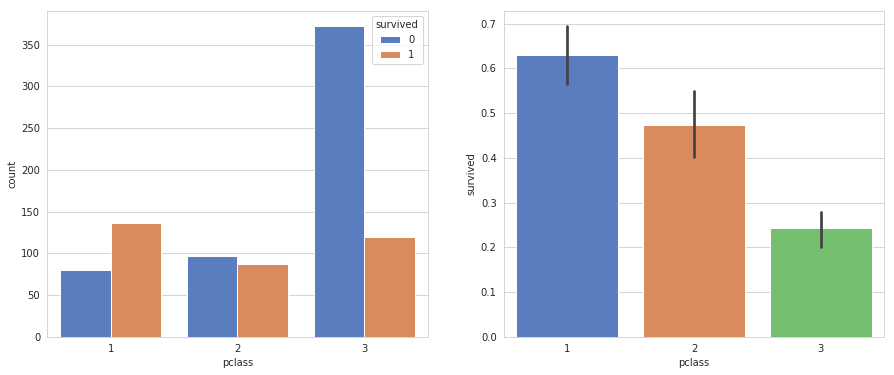

In [7]:
# survived & pclass
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.countplot(data=tmp, x='pclass', hue='survived')
plt.subplot(1, 2, 2)
sns.barplot(data=tmp, x='pclass', y='survived')
plt.show()

* **People in higher pclass were more likely to survive**

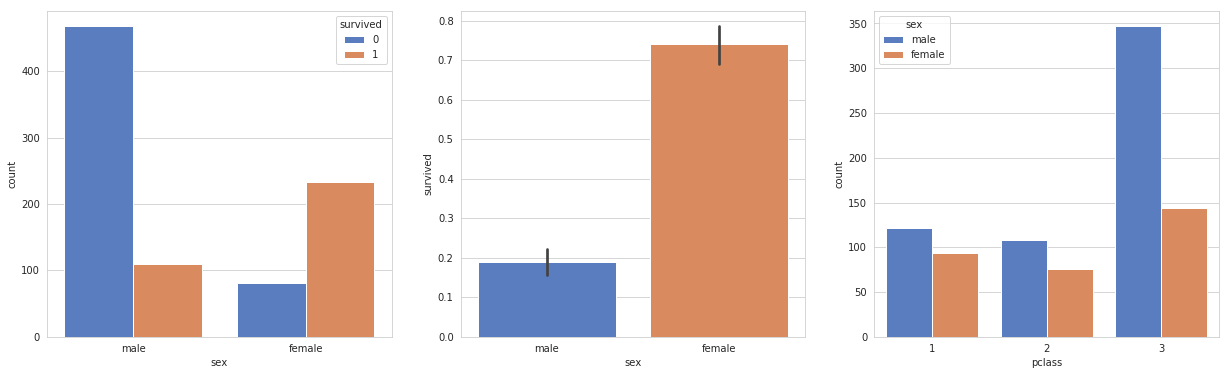

In [8]:
# survived & sex
plt.figure(figsize=(21, 6))
plt.subplot(1, 3, 1)
sns.countplot(data=tmp, x='sex', hue='survived')
plt.subplot(1, 3, 2)
sns.barplot(data=tmp, x='sex', y='survived')
plt.subplot(1, 3, 3)
sns.countplot(data=tmp, x='pclass', hue='sex')
plt.show()

* **Comparing to male, females were more likely to survive.**
* **Comparing to pclass 3, pclass 1 and pclass 2 got more females, there are interactions between sex and pclass.**

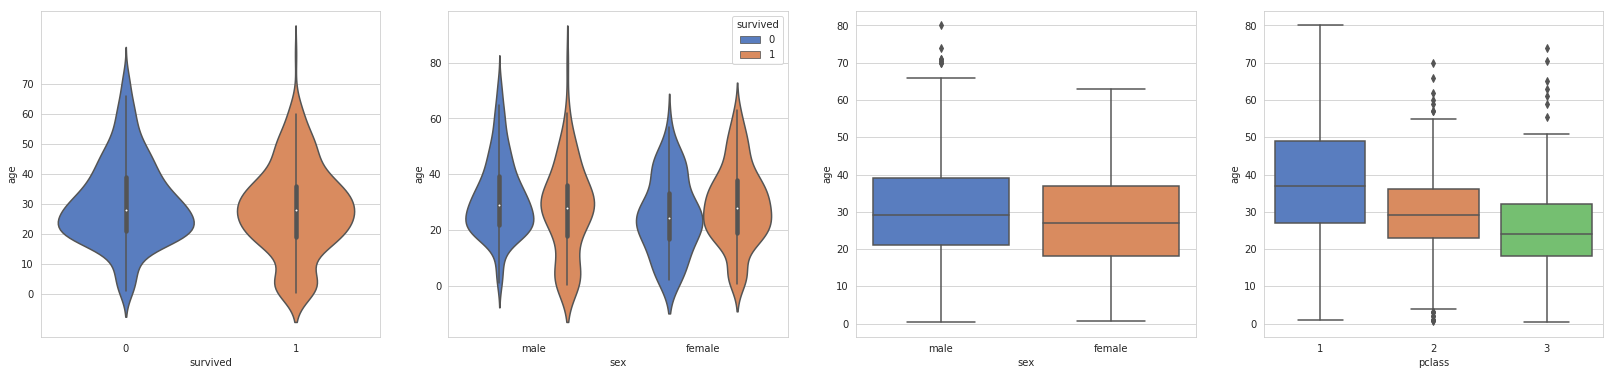

In [9]:
# survived & age
plt.figure(figsize=(28, 6))
plt.subplot(1, 4, 1)
sns.violinplot(data=tmp, x='survived', y='age')
plt.yticks(np.arange(0, 80, 10))
plt.subplot(1, 4, 2)
sns.violinplot(data=tmp, x='sex', y='age', hue='survived')
plt.subplot(1, 4, 3)
sns.boxplot(data=tmp, x='sex', y='age')
plt.subplot(1, 4, 4)
sns.boxplot(data=tmp, x='pclass', y='age')
plt.show()

* **Young people (younger than 10) were clearly more likely to survive, however, this is only true for males, females seems to be the opposite**
* **There is no clear difference in age between male and female, but people in different pclass clearly got different age**
* **People in pclass 1 seems to be the oldest, but they survived better, pclass seems to be dominant here**

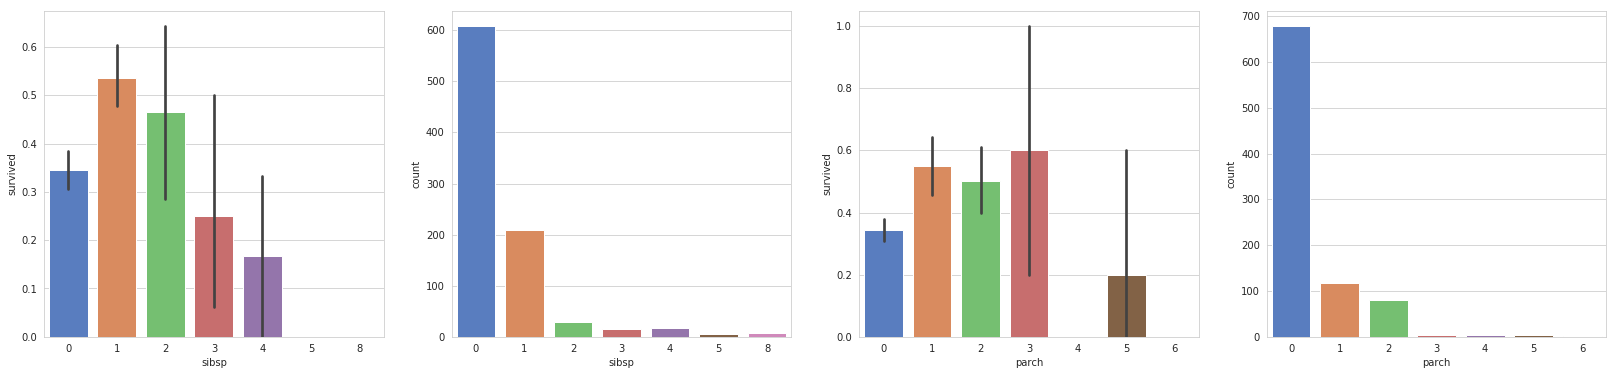

In [10]:
# sibsp and parch
plt.figure(figsize=(28, 6))
plt.subplot(1, 4, 1)
sns.barplot(data=tmp, x='sibsp', y='survived')
plt.subplot(1, 4, 2)
sns.countplot(tmp.sibsp)
plt.subplot(1, 4, 3)
sns.barplot(data=tmp, x='parch', y='survived')
plt.subplot(1, 4, 4)
sns.countplot(tmp.parch)
plt.show()

* **Sibsp and parch are 0 for most passengers**
* **Passengers with high sibsp or parch value are quite rare, which is not so good for generalization**
* **These two features seem to have similar effect on our target, combining them into one may be better**

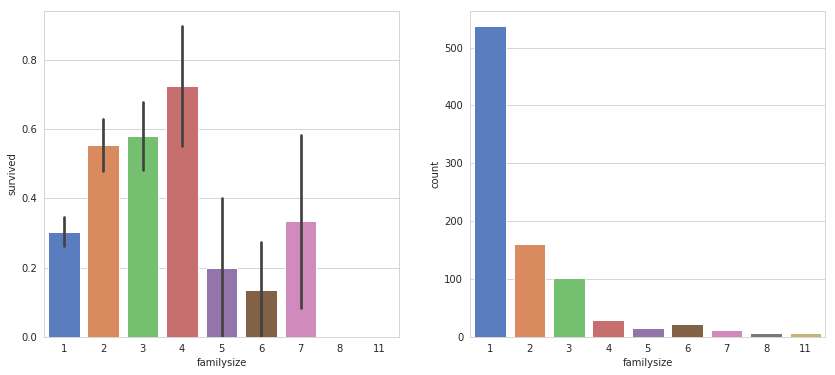

In [11]:
# Try combining sibsp and parch into familysize, which should make sense, since families tend to travel together
tmp['familysize'] = tmp['sibsp'] + tmp['parch'] + 1

# Let's see how it works
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.barplot(data=tmp, x='familysize', y='survived')
plt.subplot(1, 2, 2)
sns.countplot(tmp.familysize)
plt.show()

* **It seems better now, but still, passengers with > 3 familysize were rare**
* **It might help to group it into categories, but let's stop here for now**

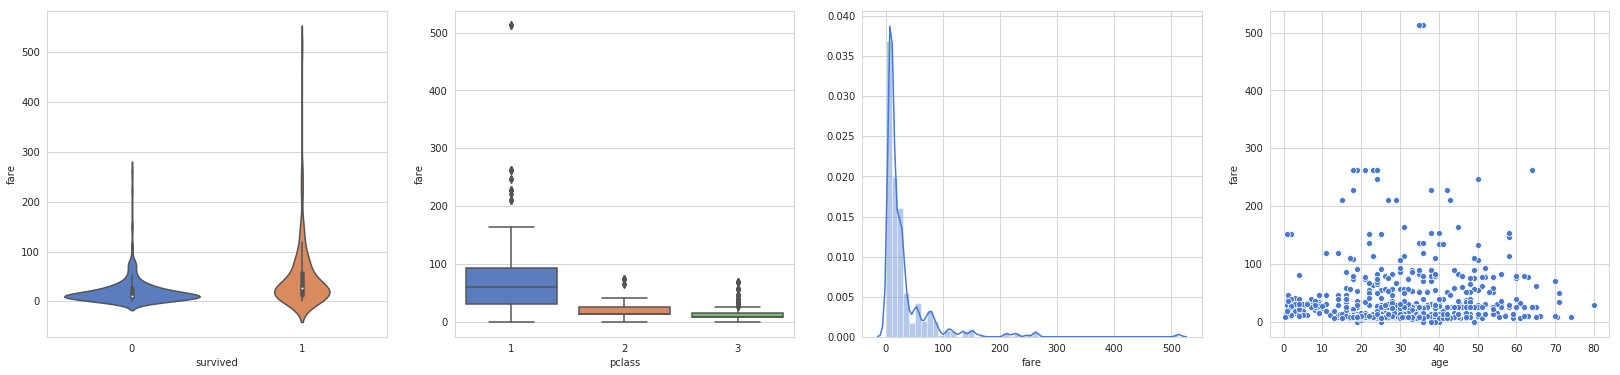

In [12]:
# survived & fare
plt.figure(figsize=(28, 6))
plt.subplot(1, 4, 1)
sns.violinplot(data=tmp, x='survived', y='fare')
plt.subplot(1, 4, 2)
sns.boxplot(data=tmp, x='pclass', y='fare')
plt.subplot(1, 4, 3)
sns.distplot(tmp.fare)
plt.subplot(1, 4, 4)
sns.scatterplot(data=tmp, x='age', y='fare')
plt.show()

* **Passengers who paid more fare were more likely to survive**
* **Fare tend to be different between different pclass and sex**
* **No predominant correlation between age and fare**
* **This feature is highly skewed, a log1p transformation could fix it**

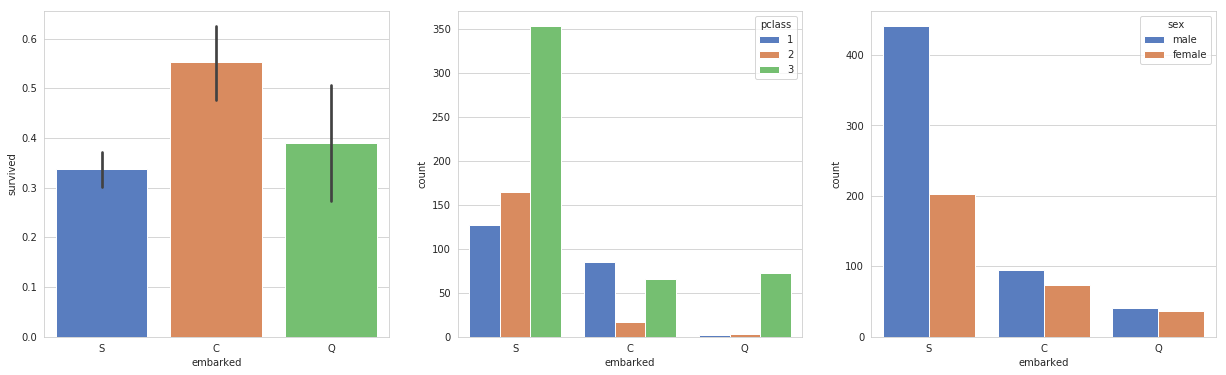

In [13]:
# embarked & survived
plt.figure(figsize=(21, 6))
plt.subplot(1, 3, 1)
sns.barplot(data=tmp, x='embarked', y='survived')
plt.subplot(1, 3, 2)
sns.countplot(data=tmp, x='embarked', hue='pclass')
plt.subplot(1, 3, 3)
sns.countplot(data=tmp, x='embarked', hue='sex')
plt.show()

* **Embarked S seems to be the worst, probably because of its high pclass 3 ratio**
* **Embarked C seems good, probably because of its high pclass 1 ratio**
* **Emabrked Q seems magical, it contains mainly pclass 3 passengers, but got about 40% survive rate, recall from the past people in pclass 3 got only about 25% survive rate**

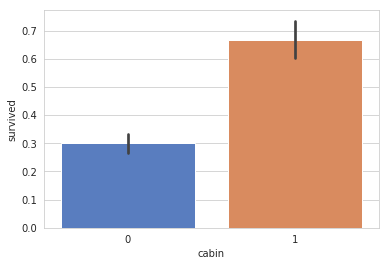

In [14]:
# Three features remains: name, ticket, and cabin
# Cabin first
# There are too many missing values in cabin, let's try converting it into a binary feature
tmp['cabin'] = tmp.cabin.notnull().astype(int)

# See how it works
sns.barplot(data=tmp, x='cabin', y='survived')
plt.show()

* **That seems help**

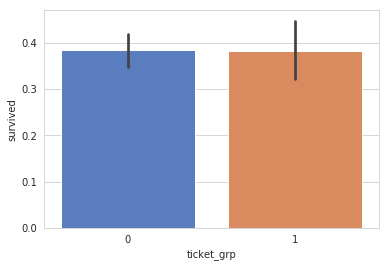

In [15]:
# Than let's see if we can extract something useful from name and ticket
# Ticket can be classified into to groups: start with letter group and all number group, that might means something
tmp['ticket_grp'] = tmp.ticket.str.contains(r'[A-Za-z]').astype(int)

# See how it works
sns.barplot(data=tmp, x='ticket_grp', y='survived')
plt.show()

* **That seems not helpful, consider just drop ticket**

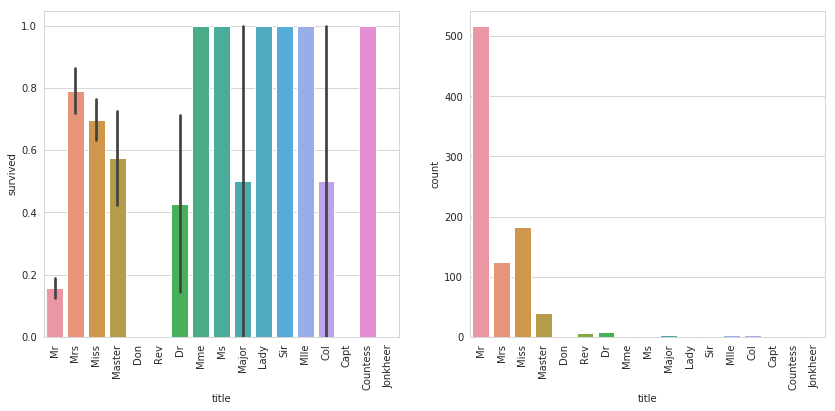

In [16]:
# Name columns contains the title in it, let's extract it
tmp['title'] = tmp.name.str.extract(r' (\w+)\.', expand=False)

# See how it works
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.barplot(data=tmp, x='title', y='survived')
plt.xticks(rotation=90)
plt.subplot(1, 2, 2)
sns.countplot(tmp.title)
plt.xticks(rotation=90)
plt.show()

* **It seems that title does have something to do with survive rate**
* **Again, there are many rare titles, which are not good for generalization, consider group them in the processing step**

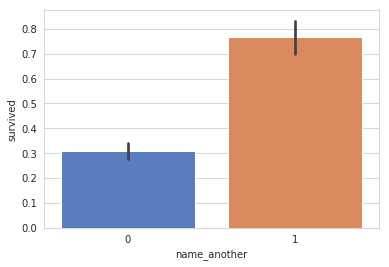

In [17]:
# Some of the names got a "()" and another name in it, that might have something to do with social status or personality
# Extract that and see how it works
tmp['name_another'] = tmp.name.str.contains(r'\(').astype(int)

sns.barplot(data=tmp, x='name_another', y='survived')
plt.show()

* **That seems help, we will keep it**

### EDA Summary
* Sex, pclass, and age have something to do with our target and there are interations among them.
* Age seems to be quite different between pclass, and so is fare, we can use that to fill in the missing values.
* Sibsp and parch basically means the same thing to the target, we can combine them into one and do some further grouping.
* Cabin needs to be transformed into a binary feature.
* Ticket does not seems to help, just drop it.
* The new features title and name_another seem to mean a lot to the target, wo may use them in our model.

### Fill in the Missing Values

In [18]:
combine['age'] = combine.groupby('pclass').age.transform(lambda x: x.fillna(x.median()))
combine['cabin'] = combine.cabin.notnull().astype(int)
combine['fare'] = combine.groupby('pclass').fare.transform(lambda x: x.fillna(x.median()))
combine['embarked'] = combine.embarked.fillna(combine.embarked.mode()[0])

In [19]:
# Check out that there are no more missing values in our data
combine.isnull().sum().sum()

0

### Feature Engineering

In [20]:
combine['title'] = combine.name.str.extract(r' (\w+)\.', expand=False)
combine['title'] = combine.title.replace({'Ms': 'Miss', 'Mme': 'Mrs'})
combine['title'] = combine.title.apply(lambda x: x if x in ['Mr', 'Miss', 'Mrs', 'Master'] else 'Rare')
combine['sex'] = combine.sex.apply(lambda x: int(x=='female'))
combine['age_child'] = combine.age.apply(lambda x: int(x<=10))
combine['familysize'] = combine.sibsp + combine.parch + 1
combine['is_alone'] = combine.familysize.apply(lambda x: int(x==1))

In [21]:
to_drop = ['name', 'sibsp', 'parch', 'ticket']
to_category = ['title', 'embarked', 'pclass']

In [22]:
combine = combine.drop(to_drop, axis=1)
for feat in to_category:
    combine[feat] = combine[feat].astype('category')
combine = pd.get_dummies(combine)

### Prepare the Data for Our Model

In [23]:
X_train = combine[:sep]
y_train = train['survived']
X_test = combine[sep:]

### Set up the Metric

In [24]:
kf = StratifiedKFold(n_splits=8, shuffle=True, random_state=0)
metric = 'accuracy'

In [25]:
def performance(model):
    score = cross_val_score(model, X_train, y_train, cv=kf, scoring=metric, n_jobs=4).mean()
    return score

def grid_search(model, params):
    grid = GridSearchCV(model, params, cv=kf, scoring=metric, verbose=True, n_jobs=4).fit(X_train, y_train)
    print(grid.best_score_)
    print(grid.best_params_)
    return grid.best_estimator_

### Grid Search for base models (Shown below is the result view, not the process)

In [26]:
base_clfs = []

In [27]:
params = {
    'n_estimators': [200],
    'max_depth': [9],
    'min_samples_split': [5],
    'random_state': [0],
    'max_features': [0.9]
}
clf = grid_search(RandomForestClassifier(), params)

Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=4)]: Done   8 out of   8 | elapsed:    1.7s finished


0.8496071829405163
{'max_depth': 9, 'max_features': 0.9, 'min_samples_split': 5, 'n_estimators': 200, 'random_state': 0}


In [28]:
base_clfs.append(clf)

In [29]:
params = {
    'n_estimators': [200],
    'max_depth': [6],
    'min_samples_split': [8],
    'random_state': [0],
    'max_features': [0.1]
}
clf = grid_search(ExtraTreesClassifier(), params)

Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=4)]: Done   8 out of   8 | elapsed:    1.1s finished


0.8383838383838383
{'max_depth': 6, 'max_features': 0.1, 'min_samples_split': 8, 'n_estimators': 200, 'random_state': 0}


In [30]:
base_clfs.append(clf)

In [31]:
params = {
    'random_state': [0],
    'n_estimators': [1000],
    'learning_rate': [0.02]
}
clf = grid_search(AdaBoostClassifier(), params)

Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=4)]: Done   8 out of   8 | elapsed:    9.2s finished


0.835016835016835
{'learning_rate': 0.02, 'n_estimators': 1000, 'random_state': 0}


In [32]:
base_clfs.append(clf)

In [33]:
params = {
    'n_estimators': [1000],
    'learning_rate': [0.02],
    'max_depth': [3],
    'random_state': [0],
    'subsample': [0.5],
    'max_features': [0.7]
}
clf = grid_search(GradientBoostingClassifier(), params)

Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=4)]: Done   8 out of   8 | elapsed:    6.5s finished


0.8552188552188552
{'learning_rate': 0.02, 'max_depth': 3, 'max_features': 0.7, 'n_estimators': 1000, 'random_state': 0, 'subsample': 0.5}


In [34]:
base_clfs.append(clf)

In [35]:
params = {
    'n_estimators': [1000],
    'learning_rate': [0.02],
    'random_state': [0],
    'max_depth': [3],
    'subsample': [0.6],
    'colsample_bytree': [1],
    'colsample_bylevel': [1],
    'reg_alpha': [1.0],
    'reg_lambda': [0.01]
}
clf = grid_search(XGBClassifier(), params)

Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=4)]: Done   8 out of   8 | elapsed:    4.3s finished


0.8518518518518519
{'colsample_bylevel': 1, 'colsample_bytree': 1, 'learning_rate': 0.02, 'max_depth': 3, 'n_estimators': 1000, 'random_state': 0, 'reg_alpha': 1.0, 'reg_lambda': 0.01, 'subsample': 0.6}


In [36]:
base_clfs.append(clf)

### Get the predictions of base_clfs for blending 

In [37]:
preds = pd.DataFrame()

for i, model in enumerate(base_clfs):
    pred = cross_val_predict(model, X_train, y_train, cv=kf, n_jobs=4, method='predict_proba')[:, 1]
    preds['model_'+str(i)] = pred

### Train a RandomForestClassifier as blender

In [38]:
params = {
    'n_estimators': [100],
    'random_state': [0],
    'max_depth': [7],
    'min_samples_split': [4],
    'max_features': [0.8]
}
grid = GridSearchCV(RandomForestClassifier(), params, cv=kf, scoring=metric, n_jobs=4, verbose=True).fit(preds, y_train)
print(grid.best_score_)
print(grid.best_params_)

Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=4)]: Done   8 out of   8 | elapsed:    1.6s finished


0.8608305274971941
{'max_depth': 7, 'max_features': 0.8, 'min_samples_split': 4, 'n_estimators': 100, 'random_state': 0}


In [39]:
blender = grid.best_estimator_

### Make predictions on test data and submit the result

In [40]:
test_preds = pd.DataFrame()
for i, model in enumerate(base_clfs):
    pred = model.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    test_preds['model_'+str(i)] = pred

In [41]:
y_pred = blender.fit(preds, y_train).predict(test_preds)
y_pred = pd.Series(y_pred, name='Survived')
sub = pd.concat([passengetid, y_pred], axis=1)

In [42]:
sub.to_csv('submission.csv', index=False)